In [4]:
from dotenv import load_dotenv
_ = load_dotenv()

## LLM

In [ ]:
from langchain_openai import ChatOpenAI

In [10]:
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke("Hello world")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-589b94a4-84a3-42d8-80ed-cbc3057da395-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [17]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [9]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [33]:
class Agent:
    def __init__(self, model, tools, system_prompt):
        self.system_prompt = system_prompt
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.action_exists,
            {
                True: "action",
                False: END
            }
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
    
    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages
        response = self.model.invoke(messages)
        return {"messages": [response]}
    
    def action_exists(self, state: AgentState):
        messages = state["messages"]
        last_message = messages[-1]
        return len(last_message.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}
    
    

In [34]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system_prompt=prompt)

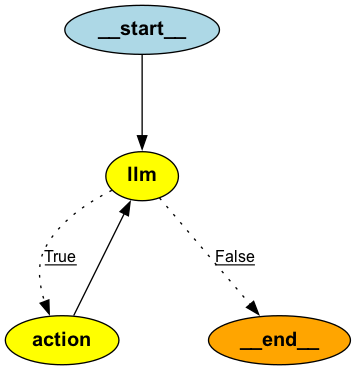

In [35]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [36]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_NdTBhGJ29yBUaN8XSVavR8wz', 'type': 'tool_call'}
Back to the model!


In [37]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NdTBhGJ29yBUaN8XSVavR8wz', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 153, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b7d49a22-2211-4a5f-b449-bacd7f31d50c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_NdTBhGJ29yBUaN8XSVavR8wz', 'type': 'tool_call'}], usage_metadata=

In [38]:
result['messages'][-1].content

'The current weather in San Francisco is 48.9°F (9.4°C). It is clear with a wind speed of 15.8 kph coming from the northwest. The humidity is at 66%, and there is no precipitation at the moment.'

In [39]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_MK9qX3m7LTmL6YclOZOqxJXW', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_BJT1xP9HagQ5eOw41Z8K0zbu', 'type': 'tool_call'}
Back to the model!


In [40]:
result['messages'][-1].content

'The current weather in San Francisco is clear with a temperature of 46.9°F, and the wind speed is 16.2 km/h coming from the northwest. In Los Angeles, the current weather is also clear with a temperature of 51.1°F, and the wind speed is 9.4 km/h coming from the west-northwest.'

In [ ]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})